In [1]:
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
import numpy as np
import vice
import sys
sys.path.append("..")
from src.utils import subsample_stellar_populations, get_velocity_profile, oh_to_12pluslog
from src.plots.utils import weighted_median, feuillet2019_data
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
outputs = [
    "../outputs/expifr/amd/base-highres",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin+0p8-highres",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8-highres"
    # "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin+0",
]
outputs = [vice.output(name) for name in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]

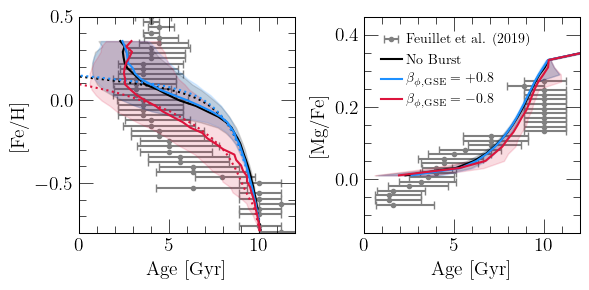

In [5]:
RMIN = 7
RMAX = 9
ABSZMIN = 0
ABSZMAX = 0.5
FEH_BINS = 40
MGFE_BINS = 20
THRESHOLD = 250
COLORS = ["black", "dodgerblue", "crimson"]
LABELS = ["No Burst", r"$\beta_{\phi,\text{GSE}} = +0.8$", r"$\beta_{\phi,\text{GSE}} = -0.8$"]

fig = plt.figure(figsize = (6, 3))
axes = []
for i in range(2):
    axes.append(fig.add_subplot(121 + i))
    axes[i].set_xlabel(r"Age [Gyr]")
    axes[i].set_xlim([0, 12])
axes[0].set_ylabel(r"[Fe/H]")
axes[1].set_ylabel(r"[Mg/Fe]")
axes[0].set_ylim([-0.8, 0.5])
axes[1].set_ylim([-0.15, 0.45])

def plot_trends(output, rmin, rmax, abszmin, abszmax, zone_width = 0.1, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "mass", ">", 1)
    feh_bins = np.linspace(*axes[0].get_ylim(), FEH_BINS + 1)
    feh_sixteen = []
    feh_medianage = []
    feh_eightyfour = []
    for i in range(FEH_BINS):
        sub = stars.filter(
            "[fe/h]", ">=", feh_bins[i]).filter(
            "[fe/h]", "<=", feh_bins[i + 1])
        if len(sub["mass"]) >= THRESHOLD:
            feh_sixteen.append(weighted_median(sub["age"], sub["mass"], stop = 0.16))
            feh_medianage.append(weighted_median(sub["age"], sub["mass"], stop = 0.5))
            feh_eightyfour.append(weighted_median(sub["age"], sub["mass"], stop = 0.84))
        else:
            feh_sixteen.append(float("nan"))
            feh_medianage.append(float("nan"))
            feh_eightyfour.append(float("nan"))
    yvals = [(a + b) / 2 for a, b in zip(feh_bins[:-1], feh_bins[1:])]
    axes[0].plot(feh_medianage, yvals, **kwargs)
    if "label" in kwargs.keys():
        label = kwargs["label"]
        kwargs["label"] = None
    else:
        label = None
    axes[0].fill_betweenx(yvals, feh_sixteen, feh_eightyfour, alpha = 0.15, **kwargs)
    if label is not None: kwargs["label"] = label

    # mgfe_bins = np.linspace(*axes[1].get_ylim(), MGFE_BINS + 1)
    mgfe_bins = np.linspace(0, 0.4, MGFE_BINS + 1)
    mgfe_sixteen = []
    mgfe_medianage = []
    mgfe_eightyfour = []
    for i in range(MGFE_BINS):
        sub = stars.filter(
            "[mg/fe]", ">=", mgfe_bins[i]).filter(
            "[mg/fe]", "<=", mgfe_bins[i + 1])
        if len(sub["mass"]) >= THRESHOLD:
            mgfe_sixteen.append(weighted_median(sub["age"], sub["mass"], stop = 0.16))
            mgfe_medianage.append(weighted_median(sub["age"], sub["mass"], stop = 0.5))
            mgfe_eightyfour.append(weighted_median(sub["age"], sub["mass"], stop = 0.84))
        else:
            mgfe_sixteen.append(float("nan"))
            mgfe_medianage.append(float("nan"))
            mgfe_eightyfour.append(float("nan"))
    yvals = [(a + b) / 2 for a, b in zip(mgfe_bins[:-1], mgfe_bins[1:])]
    axes[1].plot(mgfe_medianage, yvals, **kwargs)
    if "label" in kwargs.keys(): kwargs["label"] = None
    axes[1].fill_betweenx(yvals, mgfe_sixteen, mgfe_eightyfour, alpha = 0.15, **kwargs)

def plot_evol(output, radius, zone_width = 0.1, **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    axes[0].plot(zone.history["lookback"], zone.history["[fe/h]"], **kwargs)
    # axes[1].plot(zone.history["lookback"], zone.history["[mg/fe]"], **kwargs)

def plot_data(ax, filename, **kwargs):
    age, abundance, age_disp, abundance_disp = feuillet2019_data(filename)
    ax.errorbar(age, abundance, xerr = age_disp, yerr = None, marker = markers()["point"], **kwargs)

kwargs = {
    "color": named_colors()["grey"],
    "linestyle": "None",
    "zorder": -1000,
    "label": "Feuillet et al. (2019)"
}
plot_data(axes[0], "../data/age_mh/ELEM_GAUSS_AGE_07_09_00_05_M_H.fits", **kwargs)
plot_data(axes[1], "../data/age_alpha/ELEM_GAUSS_AGE_07_09_00_05_alpha.fits", **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "color": named_colors()[COLORS[i]],
        "label": LABELS[i]
    }
    plot_trends(outputs[i], RMIN, RMAX, ABSZMIN, ABSZMAX, **kwargs)
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": ":"
    }
    plot_evol(outputs[i], (RMIN + RMAX) / 2, **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (0.02, 0.98),    
    "handlelength": 1.5,
    "fontsize": 10
}
handles, labels = axes[1].get_legend_handles_labels()
order = [3, 0, 1, 2]
leg = axes[1].legend([handles[i] for i in order], [labels[i] for i in order], **kwargs)

# plot_trends(outputs[0], 7, 9, 0, 0.5, color = named_colors()["black"], label = r"$\b)
# plot_trends(outputs[1], 7, 9, 0, 0.5, color = named_colors()["dodgerblue"])
# plot_trends(outputs[2], 7, 9, 0, 0.5, color = named_colors()["crimson"], label = r)

# kwargs = {"linestyle": ":"}
# plot_evol(outputs[0], 8, c = named_colors()["black"], **kwargs)
# plot_evol(outputs[1], 8, c = named_colors()["dodgerblue"], **kwargs)
# plot_evol(outputs[2], 8, c = named_colors()["crimson"],  **kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./age-metallicity/amr-prograde-v-retrograde.%s" % (ext), **kwargs)
plt.show()

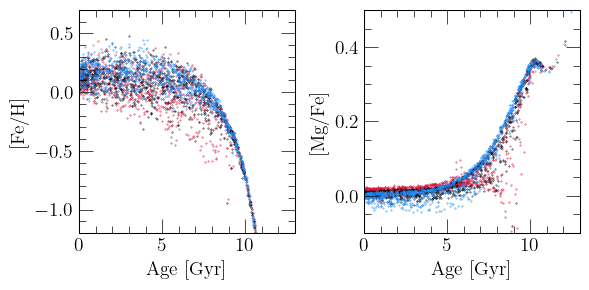

In [11]:
fig = plt.figure(figsize = (6, 3))
axes = []
for i in range(2):
    axes.append(fig.add_subplot(121 + i))
    axes[i].set_xlabel(r"Age [Gyr]")
    axes[i].set_xlim([0, 13])
axes[0].set_ylabel(r"[Fe/H]")
axes[1].set_ylabel(r"[Mg/Fe]")
axes[0].set_ylim([-1.2, 0.7])
axes[1].set_ylim([-0.1, 0.5])

def scatter_stars(output, rmin, rmax, abszmin, abszmax, zone_width = 0.1, N = 1000, seed = 0, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "mass", ">", 1)
    sub = subsample_stellar_populations(stars, N = N, seed = seed)
    axes[0].scatter(sub["age"], sub["[fe/h]"], **kwargs)
    axes[1].scatter(sub["age"], sub["[mg/fe]"], **kwargs)

scatter_stars(outputs[0], 7, 9, 0, 0.5, c = named_colors()["crimson"], s = 0.1, rasterized = True)
scatter_stars(outputs[1], 7, 9, 0, 0.5, c = named_colors()["black"], s = 0.1, rasterized = True)
scatter_stars(outputs[2], 7, 9, 0, 0.5, c = named_colors()["dodgerblue"], s = 0.1, rasterized = True)

plt.tight_layout()
plt.show()